## Pre-processing (Task 1)

Import the utility libraries

In [2]:
import pandas as pd
import math
from datetime import datetime
from matplotlib.pyplot import pie, show
import numpy as np

In [3]:
path = ""
#insert the path of the directory in which the CSVs are stored

In [4]:
def getClassDistribution(patientsBefore, patientsAfter):
  """
  The function takes account of the class distribution's
  computation.

  Parameters
  ----------
  patientsBefore : int
      represents the number of active patients before the
      filter of the dataset
  patientsAfter : int
      represents the number of active patients after the
      filter of the dataset

  Returns
  -------
  float
      the percentage of active patients rounded to the
      second decimal digit
  """
  return round((patientsAfter/patientsBefore)*100, 2)

In [5]:
def printDistribution(step_n0, step_n1):
  """
  The utility function prints the information about the
  class distribution.
  Specifically the function prints:
  - The amount of active patients before the dataset filter
  - The amount of active patients after the dataset filter
  - The percentage of patients of interest (computed on the base
  of the number of the active patients in a specific moment of the
  inspection of the dataset)
  - The percentage of patients discarded (computed on the base
  of the number of the active patients in a specific moment of the
  inspection of the dataset).
  
  Show a pie chart about the distribution of patients.

  Parameters
  ----------
  step_n0 : int
      represents the number of active patients before the
      filter of the dataset; mind that the name 'step_n0'
      and 'step_n1' is given to remember that the function
      always need the number of patients before a filter 
      and the number of patients right after the filter
  step_n1 : int
      represents the number of active patients after the
      filter of the dataset; mind that the name 'step_n0'
      and 'step_n1' is given to remember that the function
      always need the number of patients before a filter 
      and the number of patients right after the filter
  """
  patientsOfInterest = getClassDistribution(step_n0, step_n1)
  patientsDiscarded = round(100-patientsOfInterest, 2)
  print("Starting Patients:", step_n0)
  print("Remaining Patients:", step_n1)
  print("Patients of Interest:", patientsOfInterest, "%")
  print("Patients Discarded:", patientsDiscarded, "%")
  labels = ["Patients of Interest", "Patients Discarded"] 
  pie([patientsOfInterest, patientsDiscarded], labels = labels, autopct = '%1.1f%%')
  show()

In [6]:
def filterDataFrame(target_df, activePatients_df):
  """
  The function performs the filtering of a dataframe.
  Specifically the function combines the two dataframes 
  based on the columns 'idcentro' and 'idana', i.e. only
  rows with matches in the two dataframes will be returned.

  Parameters
  ----------
  target_df : DataFrame
      represents the dataframe on which the function performs
      the search
  activePatients_df : DataFrame
      represents the the dataframe of the active patients 
      with the 'idcentro', 'idana' after the perfomance of searching

  Returns
  -------
  df
      a new dataframe representing the intersection of the two initial dataframes.
  """
  return pd.merge(target_df, activePatients_df, on=['idcentro', 'idana'], how='inner')

## 1. Select event of interest

Retain only patients with **at least one cardiovascular event** in their history.

The cardiovascular events considered are *MACRO Cardiovascular events* which are the following:
* AMD047: Myocardial infraction
* AMD048: Coronary angioplasty
* AMD049: Coronary bypass
* AMD071: Ictus
* AMD081: Lower limb angioplasty
* AMD082: Peripheral By-pass Lower Limbs
* AMD208: Revascularization of intracranial and neck vessels
* AMD303: Ischemic stroke

In [7]:
codes = ['AMD047', 'AMD048', 'AMD049', 'AMD071', 'AMD081', 'AMD082', 'AMD208', 'AMD303']

In [8]:
#upload diagnosi.csv dropping the first 'Unnamed' column and the duplicate rows
diagnosi_df = pd.read_csv(path+'diagnosi.csv')

diagnosi_df = diagnosi_df.drop(columns=diagnosi_df.columns[0], 
        axis=1)

diagnosi_df = diagnosi_df.drop_duplicates(keep='first').reset_index(drop=True)

diagnosi_df.shape

(4427337, 5)

In [9]:
tmp_df = diagnosi_df[diagnosi_df['codiceamd'].isin(codes)]
tmp_df = tmp_df[['idcentro', 'idana']]
activePatients_df = tmp_df.drop_duplicates().reset_index(drop=True)

In [10]:
activePatients_df.head()

,idcentro,idana
0,1,5
1,1,36
2,1,38
3,1,61
4,1,65


In [11]:
diagnosi_df = filterDataFrame(diagnosi_df, activePatients_df)

In [12]:
#after uploading of anagraficapazientiattivi.csv, we drop some features which are not relevant for the project
anagrafica_df = pd.read_csv(path+'anagraficapazientiattivi.csv')

anagrafica_df = anagrafica_df.drop(columns=anagrafica_df.columns[0], 
        axis=1)

anagrafica_df = anagrafica_df.drop(columns=['scolarita', 'statocivile', 'professione', 'origine', 'annoprimoaccesso'], 
        axis=1)

anagrafica_df = anagrafica_df.drop_duplicates().reset_index(drop=True)

In [13]:
step_0 = anagrafica_df.shape[0]

In [14]:
anagrafica_df = filterDataFrame(anagrafica_df, activePatients_df)

Starting Patients: 250000
Remaining Patients: 50000
Patients of Interest: 20.0 %
Patients Discarded: 80.0 %


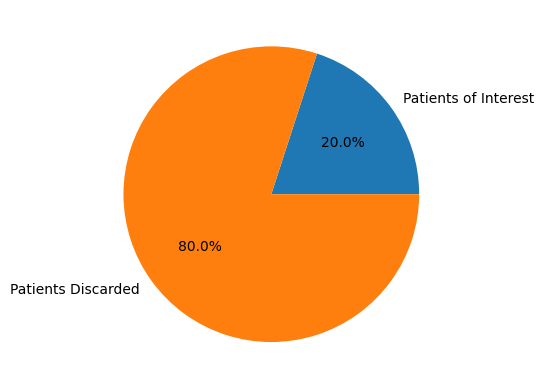

In [15]:
step_1 = anagrafica_df.shape[0]
printDistribution(step_0, step_1)

## 2. Invalid feature cleaning
Clean events with invalid date, like a particular event could not happen 
before the patient's birth or after his death.

Work on the **diagnosi.csv**

In [16]:
def cleanInvalidFeature(target_df, anagrafica_df):
  """
  The function performs the cleaning of a dataframe
  by taking away all the rows that store information
  about events whose dates are not valid (either not
  present or written as before the birth of the 
  patient or after the death of the patient) or are nan.
  Specifically the function controls if the year of event's
  date is bigger than the patient's birth and if his
  death is not nan then it checks that the year of event's
  date must be smaller than his death.

  Parameters
  ----------
  target_df : DataFrame
      represents the dataframe on which the function performs
      the search
  anagrafica_df : DataFrame
      represents the dataframe of patients with their information

  Returns
  -------
  df
      the filtered dataframe that contains only the
      events with a valid date about the patients of interest
  """
  tmp_df = pd.merge(target_df, anagrafica_df, on=['idcentro', 'idana'], how='inner')
  tmp_df = tmp_df[tmp_df['data'].notna()]
  #creates columns that are respectively year month and day of the date
  tmp_df['dataanno'] = tmp_df['data'].str[:4].astype(int)
  tmp_df['datamese'] = tmp_df['data'].str[5:7].astype(int)
  tmp_df['datagiorno'] = tmp_df['data'].str[8:].astype(int)
  c1 = tmp_df['dataanno']>tmp_df['annonascita']
  c2 = tmp_df['dataanno']<tmp_df['annodecesso']
  c3 = tmp_df['annodecesso'].isna()
  tmp_df = tmp_df[c1 & (c2 | c3)]
  tmp_df = tmp_df.drop(columns=['sesso', 'annodiagnosidiabete',	'tipodiabete', 'annonascita',	'annodecesso', 'dataanno', 'datamese', 'datagiorno'], 
        axis=1)
  return tmp_df

In [17]:
diagnosi_df = cleanInvalidFeature(diagnosi_df, anagrafica_df)
diagnosi_df.shape[0]

1911704

In [18]:
tmp_df = diagnosi_df[['idcentro', 'idana']]
activePatients_df = tmp_df.drop_duplicates(keep='first').reset_index(drop=True)

In [19]:
anagrafica_df = filterDataFrame(anagrafica_df, activePatients_df)

Starting Patients: 50000
Remaining Patients: 49912
Patients of Interest: 99.82 %
Patients Discarded: 0.18 %


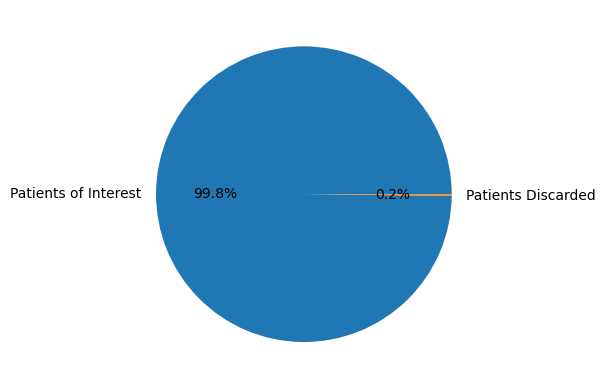

In [20]:
step_2 = anagrafica_df.shape[0]
printDistribution(step_1, step_2)

work on the **examinations** tables

In [21]:
esamiStrumentali_df = pd.read_csv(path+'esamistrumentali.csv')

esamiStrumentali_df = esamiStrumentali_df.drop(columns=esamiStrumentali_df.columns[0], 
        axis=1)

esamiStrumentali_df = esamiStrumentali_df.drop_duplicates().reset_index(drop=True)

In [22]:
esamiStrumentali_df = cleanInvalidFeature(esamiStrumentali_df, anagrafica_df)

In [23]:
esamiLaboratorioParametri_df = pd.read_csv(path+'esamilaboratorioparametri.csv')

esamiLaboratorioParametri_df = esamiLaboratorioParametri_df.drop(columns=esamiLaboratorioParametri_df.columns[0], 
        axis=1)

esamiLaboratorioParametri_df = esamiLaboratorioParametri_df.drop_duplicates().reset_index(drop=True)

In [24]:
esamiLaboratorioParametri_df = cleanInvalidFeature(esamiLaboratorioParametri_df, anagrafica_df)

In [25]:
esamiLaboratorioParametriCalcolati_df = pd.read_csv(path+'esamilaboratorioparametricalcolati.csv')

esamiLaboratorioParametriCalcolati_df = esamiLaboratorioParametriCalcolati_df.drop(columns=esamiLaboratorioParametriCalcolati_df.columns[0], 
        axis=1)

esamiLaboratorioParametriCalcolati_df = esamiLaboratorioParametriCalcolati_df.drop_duplicates().reset_index(drop=True)

In [26]:
esamiLaboratorioParametriCalcolati_df = cleanInvalidFeature(esamiLaboratorioParametriCalcolati_df, anagrafica_df)

## 3. Remove patients with all dates in the same month
Taking away patients who has short trajectory of examinations and diagnoses, specially if their events are all in one month.

In [27]:
def filterPatientsEventAllInOneMonth(target_df, activePatients_df):
  """
  The function search for patients whose trajectory is all
  condensed in one month.
  Specifically for each patients, the function retrieves all
  the dates related to the events connected to the patients
  and checks if they happened all in one single month. 
  Specifically the function removes duplicate rows based on the 
  columns 'idcentro', 'idana', 'dataanno' and 'datamese', then group
  the dataframe based on 'idcentro' and 'idana', in this way for each 
  group count the number of rows. 

  Parameters
  ----------
  target_df : DataFrame
      represents the dataframe on which the function performs
      the search
  activePatients : DataFrame
      represents the dataframe of the active patients 
      with the 'idcentro', 'idana' after the perfomance of searching

  Returns
  -------
  df
      the dataframe that containes all the patients
      whose events happened all in one month
  """
  tmp_df = pd.merge(target_df, activePatients_df, on=['idcentro', 'idana'], how='inner')
  tmp_df = tmp_df[tmp_df['data'].notna()]
  tmp_df['dataanno'] = tmp_df['data'].str[:4].astype(int)
  tmp_df['datamese'] = tmp_df['data'].str[5:7].astype(int)
  tmp_df['datagiorno'] = tmp_df['data'].str[8:].astype(int)
  tmp_df = tmp_df.drop_duplicates(subset=['idcentro', 'idana', 'dataanno', 'datamese'])
  tmp_df = tmp_df.reset_index(drop=True)
  tmp_df = tmp_df[['idcentro', 'idana']]
  tmp_df = tmp_df.groupby(['idcentro', 'idana']).size().reset_index(name='counts')
  c1 = tmp_df['counts'] == 1
  tmp_df = tmp_df[c1]
  tmp_df = tmp_df.drop(columns=['counts'], axis=1).reset_index(drop=True)
  return tmp_df

In [28]:
def filterPatientsMonthsTrajectory(diagnosi_df, esamiStrumentali_df, esamiLaboratorioParametri_df, esamiLaboratorioParametriCalcolati_df, activePatients_df):
  """
  The function call the function 'filterPatientsEventAllInOneMonth'
  for all 4 input dataframes, then join all filtered dataframes. 
  Then merge activePatients_df in the left way with the filtered dataframe which contains 
  ids of patients who have all events in one month, keeping only 
  ids of patients from the left dataframe, activePatients_df, so in this way
  can take away patients came from the filtered dataframe.

  Parameters
  ----------
  diagnosi_df : DataFrame
      represents the dataframe of diagnosi
  esamiStrumentali_df : DataFrame
      represents the dataframe of esami strumentali
  esamiLaboratorioParametri_df : DataFrame
      represents the dataframe of esami laboratorio parametri
  esamiLaboratorioParametriCalcolati_df : DataFrame
      represents the dataframe of esami laboratorio parametri calcolati

  activePatients : DataFrame
      represents the the dataframe of the active patients 
      with the 'idcentro', 'idana' after the perfomance of searching

  Returns
  -------
  df
      the filtered dataframe that contains only the
      ids of patiens of interest
  """
  patientsDiagnosiOneMonth_df = filterPatientsEventAllInOneMonth(diagnosi_df, activePatients_df)
  patientsEsamiStrumentali_df = filterPatientsEventAllInOneMonth(esamiStrumentali_df, activePatients_df)
  patientsEsamiLaboratorioParametri_df = filterPatientsEventAllInOneMonth(esamiLaboratorioParametri_df, activePatients_df)
  patientsEsamiLaboratorioParametriCalcolati_df = filterPatientsEventAllInOneMonth(esamiLaboratorioParametriCalcolati_df, activePatients_df)
  tmp_df = pd.merge(patientsDiagnosiOneMonth_df, patientsEsamiStrumentali_df, how='inner', on=['idcentro', 'idana'])
  tmp_df = pd.merge(tmp_df, patientsEsamiLaboratorioParametri_df, how='inner', on=['idcentro', 'idana'])
  tmp_df = pd.merge(tmp_df, patientsEsamiLaboratorioParametriCalcolati_df, how='inner', on=['idcentro', 'idana'])
  tmp_df = activePatients_df.merge(tmp_df.drop_duplicates(), on=['idcentro','idana'], 
                   how='left', indicator=True)
  #keep ids just from activePatients_df, not from both df
  c1 = tmp_df['_merge'] == 'left_only'
  c2 = tmp_df['_merge'] == 'both'
  tmp = tmp_df[c2]
  tmp_df = tmp_df[c1]
  tmp_df = tmp_df.drop(columns=['_merge'], axis=1).reset_index(drop=True)
  return tmp_df

In [29]:
activePatients_df = filterPatientsMonthsTrajectory(diagnosi_df, esamiStrumentali_df, esamiLaboratorioParametri_df, esamiLaboratorioParametriCalcolati_df, activePatients_df)

In [30]:
anagrafica_df = filterDataFrame(anagrafica_df, activePatients_df)

Starting Patients: 49912
Remaining Patients: 49590
Patients of Interest: 99.35 %
Patients Discarded: 0.65 %


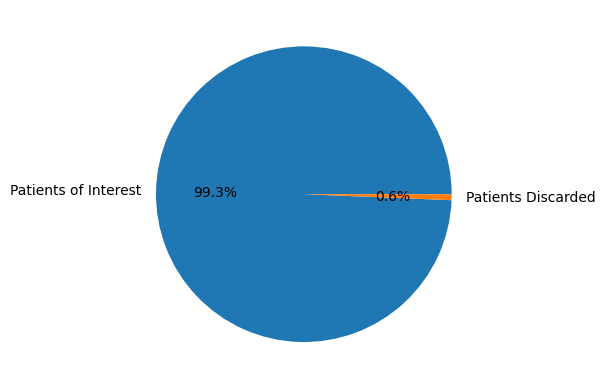

In [31]:
step_3 = anagrafica_df.shape[0]
printDistribution(step_2, step_3)

clean invalid feature on **prescrizioni** table

In [32]:
prescrDNF_df = pd.read_csv(path+'prescrizionidiabetenonfarmaci.csv')

prescrDNF_df = prescrDNF_df.drop(columns=prescrDNF_df.columns[0], 
        axis=1)

prescrDNF_df = prescrDNF_df.drop_duplicates().reset_index(drop=True)

In [33]:
prescrDNF_df = filterDataFrame(prescrDNF_df, activePatients_df)

In [34]:
prescrDNF_df = cleanInvalidFeature(prescrDNF_df, anagrafica_df)

In [35]:
activePatients = prescrDNF_df[['idcentro', 'idana']]
activePatients = activePatients.drop_duplicates(keep='first').reset_index(drop=True)

In [36]:
prescrDNF_df = filterDataFrame(prescrDNF_df, activePatients_df)

In [37]:
prescrDF_df = pd.read_csv(path+'prescrizionidiabetefarmaci.csv')

prescrDF_df = prescrDF_df.drop(columns=prescrDF_df.columns[0], 
        axis=1)

prescrDF_df = prescrDF_df.drop_duplicates().reset_index(drop=True)

In [38]:
prescrDF_df = filterDataFrame(prescrDF_df, activePatients_df)

In [39]:
prescrDF_df = cleanInvalidFeature(prescrDF_df, anagrafica_df)

In [40]:
activePatients = prescrDF_df[['idcentro', 'idana']]
activePatients = activePatients.drop_duplicates(keep='first').reset_index(drop=True)

In [41]:
prescrDF_df = filterDataFrame(prescrDF_df, activePatients_df)

In [42]:
prescrND_df = pd.read_csv(path+'prescrizioninondiabete.csv')

prescrND_df = prescrND_df.drop(columns=prescrND_df.columns[0], 
        axis=1)

prescrND_df = prescrND_df.drop_duplicates().reset_index(drop=True)

In [43]:
prescrND_df = filterDataFrame(prescrND_df, activePatients_df)

In [44]:
prescrND_df = cleanInvalidFeature(prescrND_df, anagrafica_df)

In [45]:
activePatients = prescrND_df[['idcentro', 'idana']]
activePatients = activePatients.drop_duplicates(keep='first').reset_index(drop=True)

In [46]:
prescrND_df = filterDataFrame(prescrND_df, activePatients_df)

update **exminations', diagnoses' and anagrafica's tables**

In [47]:
esamiStrumentali_df = filterDataFrame(esamiStrumentali_df, activePatients_df)

In [48]:
esamiLaboratorioParametri_df = filterDataFrame(esamiLaboratorioParametri_df, activePatients_df)

In [49]:
esamiLaboratorioParametriCalcolati_df = filterDataFrame(esamiLaboratorioParametriCalcolati_df, activePatients_df)

In [50]:
diagnosi_df = filterDataFrame(diagnosi_df, activePatients_df)

In [51]:
anagrafica_df = filterDataFrame(anagrafica_df, activePatients_df)

Starting Patients: 49590
Remaining Patients: 49590
Patients of Interest: 100.0 %
Patients Discarded: 0.0 %


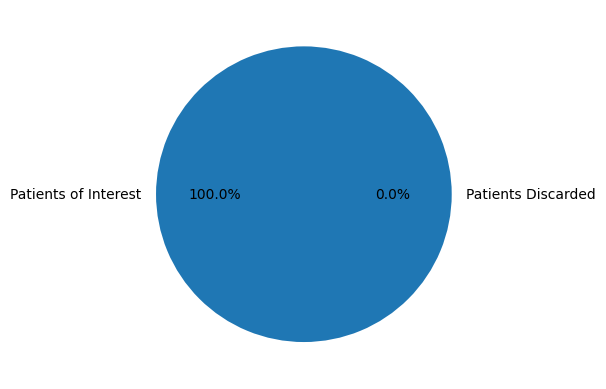

In [52]:
step_4 = anagrafica_df.shape[0]
printDistribution(step_3, step_4)

## 4. Modify the actual range

We are going to modify the columns "valore" according to some giving codes and the real range. <br>
In fact, if a value associated to a specific code is less than the minimum of the true range, <br>
it will be replaced with the minimum value, the same thing for the maximum value.

In the table **esami laboratorio parametri** there are AMD codes. These analysed codes with the true range are following: 
* AMD004: 40 ≤ x ≤ 200
* AMD005: 40 ≤ x ≤ 130
* AMD007: 50 ≤ x ≤ 500
* AMD008: 5 ≤ x ≤ 15

In [53]:
bound_values_AMD = {
  'AMD004' : (40, 200),
  'AMD005' : (40, 130),
  'AMD007' : (50, 500),
  'AMD008' : (5, 15)
}

for codice, bounds in bound_values_AMD.items():
  c1 = esamiLaboratorioParametri_df['codiceamd'] == codice
  tmp_df = esamiLaboratorioParametri_df[c1]
  c2 = esamiLaboratorioParametri_df['codiceamd'] != codice
  esamiLaboratorioParametri_df = esamiLaboratorioParametri_df[c2]
  #if column 'valore' got a value less than than the minimum of the actual range, the value will replace with minimum
  tmp_df['valore'] = tmp_df['valore'].apply(lambda x : bounds[0] if x < bounds[0] else x)
  #if column 'valore' got a value more than than the maximum of the actual range, the value will replace with maximum
  tmp_df['valore'] = tmp_df['valore'].apply(lambda x : bounds[1] if x > bounds[1] else x)
  esamiLaboratorioParametri_df = pd.concat([esamiLaboratorioParametri_df, tmp_df]).reset_index(drop=True)

In [54]:
esamiLaboratorioParametri_df = filterDataFrame(esamiLaboratorioParametri_df, activePatients_df)

In [55]:
anagrafica_df = filterDataFrame(anagrafica_df, activePatients_df)

In the table **esami laboratorio parametri calcolati** there are STITCH codes. These analysed codes with the true range are following: 
* STITCH002: 30 ≤ x ≤ 300
* STITCH003: 60 ≤ x ≤ 330

In [56]:
bound_values_STITCH = {
  'STITCH002' : (30, 300),
  'STITCH003' : (60, 330)
}

for codice, bounds in bound_values_STITCH.items():
  c1 = esamiLaboratorioParametriCalcolati_df['codicestitch'] == codice
  tmp_df = esamiLaboratorioParametriCalcolati_df[c1]
  c2 = esamiLaboratorioParametriCalcolati_df['codicestitch'] != codice
  esamiLaboratorioParametriCalcolati_df = esamiLaboratorioParametriCalcolati_df[c2]
  tmp_df['valore'] = tmp_df['valore'].apply(lambda x : bounds[0] if x < bounds[0] else x)
  tmp_df['valore'] = tmp_df['valore'].apply(lambda x : bounds[1] if x > bounds[1] else x)
  esamiLaboratorioParametriCalcolati_df = pd.concat([esamiLaboratorioParametriCalcolati_df, tmp_df]).reset_index(drop=True)

In [57]:
esamiLaboratorioParametriCalcolati_df = filterDataFrame(esamiLaboratorioParametriCalcolati_df, activePatients_df)

In [58]:
anagrafica_df = filterDataFrame(anagrafica_df, activePatients_df)

Starting Patients: 49590
Remaining Patients: 49590
Patients of Interest: 100.0 %
Patients Discarded: 0.0 %


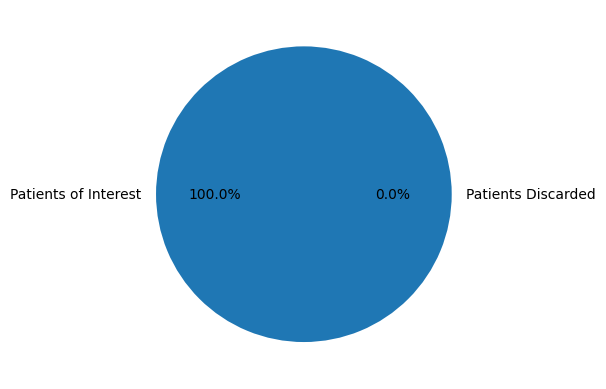

In [59]:
step_5 = anagrafica_df.shape[0]
printDistribution(step_4, step_5)

## 5. Cohort selection and label definition

The goal is the elimination of the patients that have a trajectory shorter than or equal to 6 months. <br>
We start to unify all the dataframes into one.

In [60]:
tot_col = set()
tot_col = tot_col.union(set(prescrDNF_df.columns))
tot_col = tot_col.union(set(prescrDF_df.columns))
tot_col = tot_col.union(set(prescrND_df.columns))
tot_col = tot_col.union(set(esamiStrumentali_df.columns))
tot_col = tot_col.union(set(esamiLaboratorioParametri_df.columns))
tot_col = tot_col.union(set(esamiLaboratorioParametriCalcolati_df.columns))
tot_col = tot_col.union(set(diagnosi_df.columns))
tot_col = list(tot_col)

In [61]:
#reorders the columns of the dataframes according to the order specified in the tot_col 
#which is a set contains all columns' name
prescrDNF_df = prescrDNF_df.reindex(columns = tot_col)
prescrDF_df = prescrDF_df.reindex(columns = tot_col)
prescrND_df = prescrND_df.reindex(columns = tot_col)
esamiStrumentali_df = esamiStrumentali_df.reindex(columns = tot_col)
esamiLaboratorioParametri_df = esamiLaboratorioParametri_df.reindex(columns = tot_col)
esamiLaboratorioParametriCalcolati_df = esamiLaboratorioParametriCalcolati_df.reindex(columns = tot_col)
diagnosi_df = diagnosi_df.reindex(columns = tot_col)

In [62]:
new_path = path + 'tmp_events.csv' #this is the path of a new csv that we are writing

In [63]:
#Write all diagnoses, examinations and prescriptions into a CSV file.
prescrDNF_df.to_csv(new_path, mode='w', header=True, index=False)
prescrDF_df.to_csv(new_path, mode='a', header=False, index=False)
prescrND_df.to_csv(new_path, mode='a', header=False, index=False)
esamiStrumentali_df.to_csv(new_path, mode='a', header=False, index=False)
esamiLaboratorioParametri_df.to_csv(new_path, mode='a', header=False, index=False)
esamiLaboratorioParametriCalcolati_df.to_csv(new_path, mode='a', header=False, index=False)
diagnosi_df.to_csv(new_path, mode='a', header=False, index=False)

In [ ]:
#Read from the new csv which contains a dataframe with all events.
events_df = pd.read_csv(new_path)

**Eliminate the patients that have a trajectory shorter than or equal to 6 months.**

Start to find the maximum date and the minimum date, if the maximum date is subtracted by<br>
6 months and the resulting number is greater than the minimum date, the patient’s trajectory <br>
is longer than 6 months, for this reason we keep that patient

In [65]:
tmp_events_df = events_df.groupby(by=['idcentro', 'idana'], as_index=False).agg(datamin = ('data', 'min'), datamax = ('data', 'max'))
tmp_events_df['datamin'] = pd.to_datetime(tmp_events_df['datamin'])
tmp_events_df['datamax'] = pd.to_datetime(tmp_events_df['datamax'])
c1 = (tmp_events_df['datamax'] - pd.DateOffset(months=6)) > tmp_events_df['datamin']
tmp_events_df = tmp_events_df[c1]
tmp_events_df = pd.merge(events_df, tmp_events_df, on=['idcentro', 'idana'], how='inner')

**calculate the label for all patients**

calculate the date of macro-events that is different from the maximum date and<br>
add up six months, if the result is greater than the maximum date<br>
it means the patient has had a cardiovascular event in the six months since the last date, <br>
so the patient is labelled 1. Other patients who do not meet the condition are labelled 0.

In [66]:
tmp_events_df['data'] = pd.to_datetime(tmp_events_df['data'])
c1 = tmp_events_df['data'] != tmp_events_df['datamax']
tmp_df = tmp_events_df[c1]
c2 = (tmp_df['data'] + pd.DateOffset(months=6)) > tmp_df['datamax'] 
tmp_df = tmp_df[c2]
tmp_df = tmp_df.groupby(['idcentro', 'idana'], as_index=False)['codiceamd'].apply(lambda x: (x.isin(codes)).sum())
tmp_df = tmp_df.rename(columns={'codiceamd' : 'count'})
tmp_df = pd.merge(tmp_events_df, tmp_df, on=['idcentro', 'idana'], how='left')

In [67]:
condition1 = np.logical_and(tmp_events_df['idcentro'] == tmp_df['idcentro'], tmp_events_df['idana'] == tmp_df['idana'])
condition2 = tmp_df['count'] > 0
condition = np.logical_and(condition1, condition2)
tmp_events_df['label'] = np.where(condition, 1, 0) 

In [68]:
tmp_events_df = tmp_events_df.drop(columns=['datamin'], axis=1)

In [69]:
definitive_df = pd.merge(tmp_events_df, anagrafica_df, on=['idcentro', 'idana'], how='inner')
definitive_df.shape[0]

15773194

In [70]:
definitive_df.head()

,codiceamd,data,valore,codiceatc,quantita,idpasto,descrizionefarmaco,idana,codicestitch,idcentro,datamax,label,sesso,annodiagnosidiabete,tipodiabete,annonascita,annodecesso
0,AMD152,2008-06-20,NaN,NaN,NaN,NaN,NaN,5,NaN,1,2013-12-31,1,M,1986.0,5,1942,2014.0
1,AMD152,2013-08-27,NaN,NaN,NaN,NaN,NaN,5,NaN,1,2013-12-31,1,M,1986.0,5,1942,2014.0
2,AMD086,2013-12-31,S,NaN,NaN,NaN,NaN,5,NaN,1,2013-12-31,1,M,1986.0,5,1942,2014.0
3,AMD228,2013-12-31,S,NaN,NaN,NaN,NaN,5,NaN,1,2013-12-31,1,M,1986.0,5,1942,2014.0
4,NaN,2005-01-18,NaN,A10BA02,2.0,1.0,METFORAL*50CPR RIV 500mg,5,NaN,1,2013-12-31,1,M,1986.0,5,1942,2014.0


In [71]:
new_path = path + 'definitive_dataset.csv'

In [72]:
definitive_df.to_csv(new_path, mode='w', header=True, index=False)

Starting Patients: 49590
Remaining Patients: 47702
Patients of Interest: 96.19 %
Patients Discarded: 3.81 %


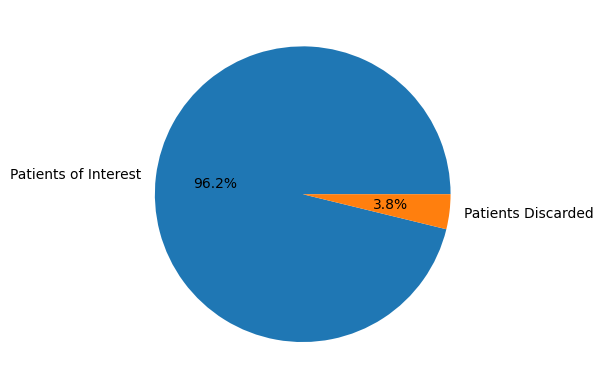

In [73]:
tmp_df = definitive_df[['idcentro', 'idana', 'label']]
activePatients_df = tmp_df.drop_duplicates().reset_index(drop=True)
step_5 = activePatients_df.shape[0]
printDistribution(step_4, step_5)

Starting Patients: 250000
Remaining Patients: 47702
Patients of Interest: 19.08 %
Patients Discarded: 80.92 %


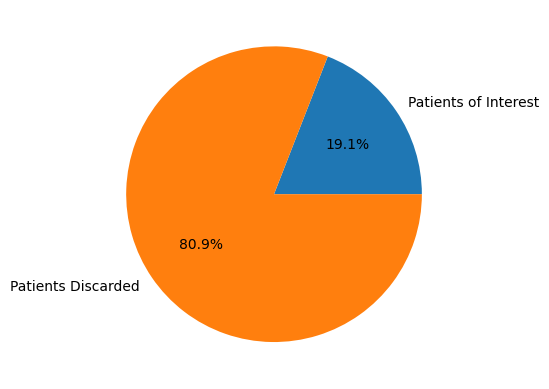

In [74]:
printDistribution(step_0, step_5)

In [75]:
c = activePatients_df['label'] == 1
tmp_df = activePatients_df[c]
gotCardiovascularPatients = tmp_df.shape[0]
c = activePatients_df['label'] == 0
tmp_df = activePatients_df[c]
notCardiovascularPatients = tmp_df.shape[0]

# Patients with Cardiovascular Events: 8980
# Patients not with Cardiovascular Events: 38722
% Patients with Cardiovascular Events: 18.83 %
% Patients not with Cardiovascular Events: 81.17 %


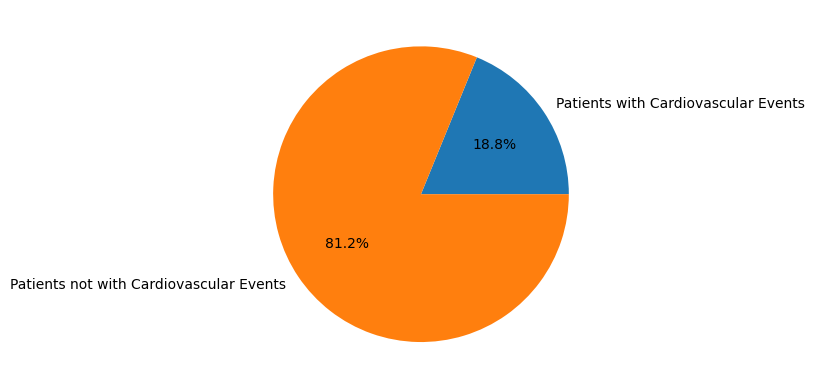

In [76]:
patientCE = getClassDistribution((notCardiovascularPatients+gotCardiovascularPatients), gotCardiovascularPatients)
patientNCE = round(100-patientCE, 2)
print("# Patients with Cardiovascular Events:", gotCardiovascularPatients)
print("# Patients not with Cardiovascular Events:", notCardiovascularPatients)
print("% Patients with Cardiovascular Events:", patientCE, "%")
print("% Patients not with Cardiovascular Events:", patientNCE, "%")
labels = ["Patients with Cardiovascular Events", "Patients not with Cardiovascular Events"] 
pie([patientCE, patientNCE], labels = labels, autopct = '%1.1f%%')
show()

In [77]:
start = definitive_df.shape[0]
c = definitive_df['label'] == 1
definitive_df = definitive_df[c]
cardiovascularEvents = definitive_df.shape[0]
notCardiovascularEvents = start - cardiovascularEvents

# Cardiovascular Events: 3273605
# Not Cardiovascular Events: 12499589
% Cardiovascular Events: 20.75 %
% Not Cardiovascular Events: 79.25 %


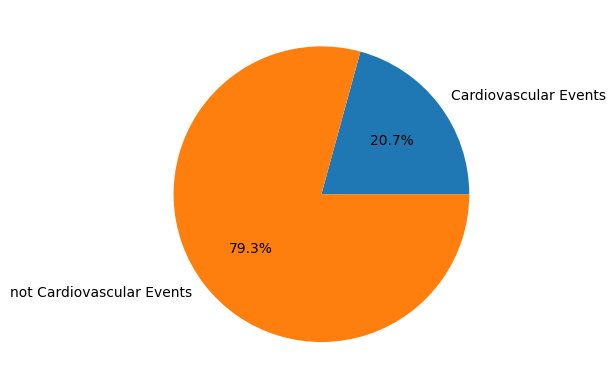

In [78]:
CE = getClassDistribution((notCardiovascularEvents+cardiovascularEvents), cardiovascularEvents)
NCE = round(100-CE, 2)
print("# Cardiovascular Events:", cardiovascularEvents)
print("# Not Cardiovascular Events:", notCardiovascularEvents)
print("% Cardiovascular Events:", CE, "%")
print("% Not Cardiovascular Events:", NCE, "%")
labels = ["Cardiovascular Events", "not Cardiovascular Events"] 
pie([CE, NCE], labels = labels, autopct = '%1.1f%%')
show()